In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import spatial_maps as sp
import septum_mec.analysis.data_processing as dp
import expipe
import os
import neo
import pathlib
import numpy as np
import elephant as el
import exdir
from scipy.interpolate import interp1d
import pandas as pd
import optogenetics as og
import quantities as pq
import pycwt
import exdir.plugins.quantities

11:49:08 [I] klustakwik KlustaKwik2 version 0.2.6


In [5]:
plt.rcParams['figure.figsize'] = (9, 6)

In [6]:
project_path = os.environ.get("SEPTUM_MEC_DATA")
if project_path is None:
    raise Exception("Need to set `SEPTUM_MEC_DATA` as environment variable first.")
else:
    project_path = pathlib.Path(project_path)

project = expipe.get_project(project_path)
actions = project.actions

In [55]:
action_id = "1833-120619-4"
channel_group = 3

channel = 1 # 0-3

action  = actions[action_id]

data_path = pathlib.Path(project_path) / "actions" / action_id / "data" / "main.exdir"
root_group = exdir.File(
    data_path, plugins=[exdir.plugins.quantities, exdir.plugins.git_lfs])

anas = dp.load_lfp(data_path, channel_group)

data = np.array(anas)[:, channel]
    
sampling_rate = anas.sampling_rate.magnitude

sampling_period = 1 / sampling_rate

times = np.arange(0, anas.shape[0] / sampling_rate, 1 / sampling_rate)

In [56]:
stim_times = root_group['epochs']['open-ephys-epochs']['rhythm_fpga_100']['timestamps'].data.magnitude
stim_durations = root_group['epochs']['open-ephys-epochs']['rhythm_fpga_100']['durations'].data.magnitude

In [57]:
print('stimulation frequency', 1 / np.diff(stim_times).mean())

stimulation frequency 30.30187709636872


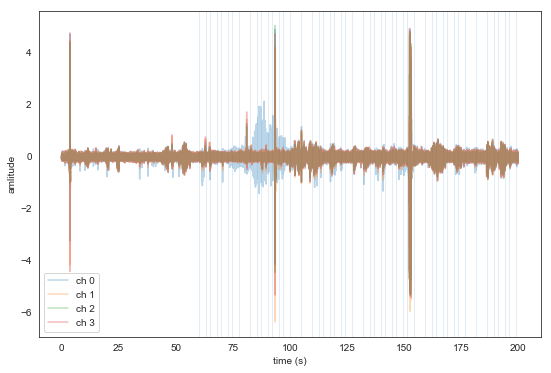

In [54]:
start_time = 0
stop_time = 200

mask = (start_time < times) & (times < stop_time) # seconds
mask_ts = (start_time < stim_times) & (stim_times < stop_time) # seconds

plt.figure()
for ch in range(4):
    plt.plot(times[mask], np.array(anas)[mask, ch], alpha=.3, label='ch {}'.format(ch))
for t, d in zip(stim_times[mask_ts], stim_durations[mask_ts]):
    plt.axvspan(t, t + d, alpha=.5)
plt.ylabel('amlitude')
plt.xlabel('time (s)')
plt.legend()

In [43]:
def mask_coi(power, freqs, coi):
    periods = 1 / freqs
    for i in range(power.shape[1]):
        mask = periods > coi[i]
        power[mask, i] = np.nan

Text(0.5, 0, 'time (s)')

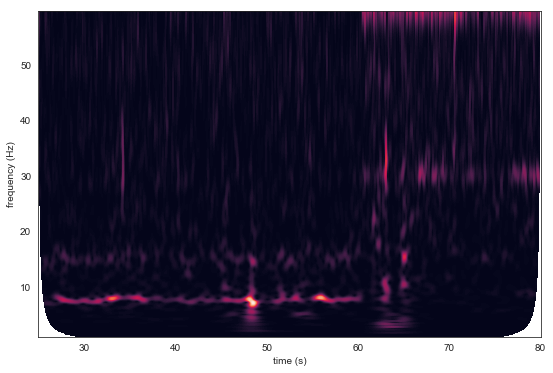

In [58]:
start_time = 25
stop_time = 80

mask = (start_time < times) & (times < stop_time) # seconds
mask_ts = (start_time < stim_times) & (stim_times < stop_time) # seconds

mother = pycwt.Morlet(20)
freqs = np.arange(1, 60, .1)

wave, scales, freqs, coi, fft, fftfreqs = pycwt.cwt(data[mask], sampling_period, freqs=freqs, wavelet=mother)

power = (np.abs(wave)) ** 2
power /= scales[:, None] #rectify the power spectrum according to suggestions proposed by Liu et al. (2007)

mask_coi(power, freqs, coi)

plt.figure()
plt.contourf(times[mask], freqs, power, levels=100)
# for t, d in zip(stim_times[mask_ts], stim_durations[mask_ts]):
#     axvspan(t, t + d, alpha=.5)
    
plt.ylabel('frequency (Hz)')
plt.xlabel('time (s)')

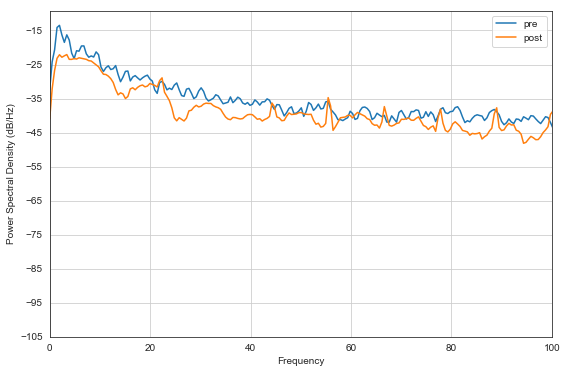

In [17]:
start_time_1 = 0
stop_time_1 = 60

start_time_2 = 100
stop_time_2 = 160

mask_1 = (start_time_1 < times) & (times < stop_time_1) # seconds
mask_2 = (start_time_2 < times) & (times < stop_time_2) # seconds

plt.figure()
plt.psd(data[mask_1], Fs=sampling_rate, NFFT=2056, label='pre')
plt.psd(data[mask_2], Fs=sampling_rate, NFFT=2056, label='post')
plt.xlim(0,100)
plt.legend()